### Are f1 scores correlated with cosine similarity or jaccard similarity?

In [16]:
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

models_and_filters = ['Social Media','News','Conversation','Wiki & Books','Legal','dannet' ,"Web"]

with open("f1_scores/f1_scores_regularized_third.pkl", "rb") as fp:
    reg_f1 = pickle.load(fp)

with open("jaccard.pkl", "rb") as fp:
    jaccard = pickle.load(fp)
    jaccard.pop(None)

with open("similarity.pkl", "rb") as fp:
    similarity = pickle.load(fp)



In [2]:
reg_f1

{'Social Media': {'Social Media': 0.7899159663865547,
  'News': 0.6967741935483871,
  'Conversation': 0.6292134831460675,
  'Wiki & Books': 0.5147540983606558,
  'Legal': 0.503242542153048,
  'dannet': 0.7272727272727273,
  'Web': 0.5927583401139137},
 'News': {'Social Media': 0.5904761904761904,
  'News': 0.9261744966442953,
  'Conversation': 0.6426592797783933,
  'Wiki & Books': 0.6482504604051565,
  'Legal': 0.495364238410596,
  'dannet': 0.6666666666666666,
  'Web': 0.6566948130277442},
 'Conversation': {'Social Media': 0.6542056074766355,
  'News': 0.7380952380952381,
  'Conversation': 0.8225806451612903,
  'Wiki & Books': 0.5708737864077671,
  'Legal': 0.5510204081632654,
  'dannet': 0.7272727272727273,
  'Web': 0.5969498910675382},
 'Wiki & Books': {'Social Media': 0.5411764705882354,
  'News': 0.806201550387597,
  'Conversation': 0.7066246056782334,
  'Wiki & Books': 0.8448275862068966,
  'Legal': 0.4461077844311377,
  'dannet': 0.888888888888889,
  'Web': 0.5497697484945094},


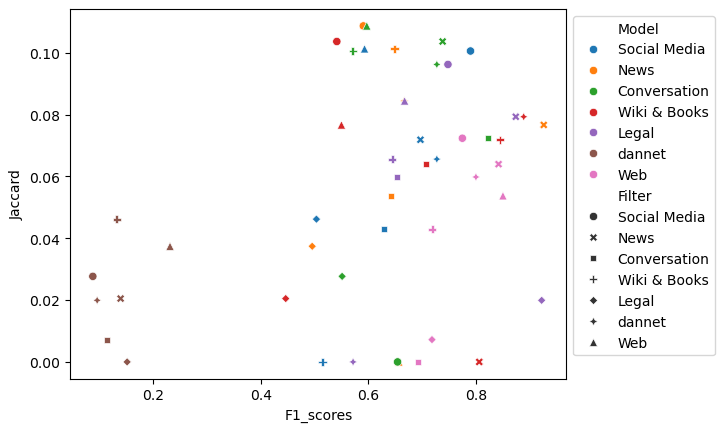

In [3]:
dfs = []

for model_type in models_and_filters:
    dfs.append(pd.DataFrame({'Model': [model_type]*7, 
                'Filter': reg_f1[model_type].keys(),
                'F1_scores': reg_f1[model_type].values(),
                "Cosine": similarity[model_type].values(),
                "Jaccard": jaccard[model_type].values()}))

plotting_df = pd.concat(dfs)


ax = sns.scatterplot(data=plotting_df, x="F1_scores", y="Jaccard", hue="Model",style="Filter")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

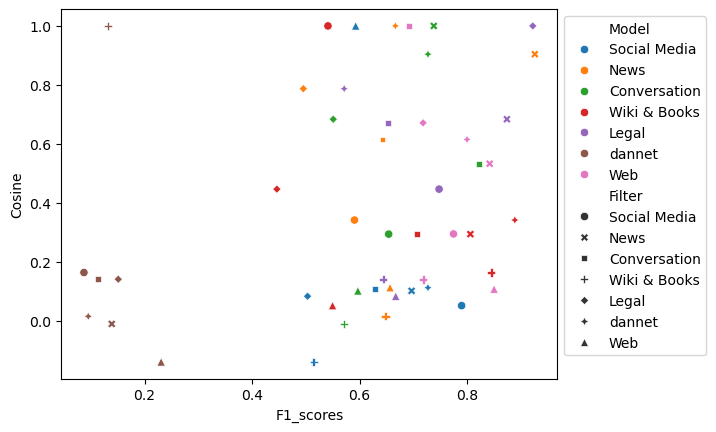

In [4]:


ax = sns.scatterplot(data=plotting_df, x="F1_scores", y="Cosine", hue="Model",style="Filter")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

### F1 scores on target domain for all baseline models

In [5]:
def load_f1scores_from_dict(f1):

    dfs = []

    for model_type in models_and_filters:
        dfs.append(pd.DataFrame({'Model': [model_type]*7, 
                    'Filter': f1[model_type].keys(),
                    'F1_scores': f1[model_type].values()}))
    
    return pd.concat(dfs).pivot(index="Model", columns="Filter", values="F1_scores")


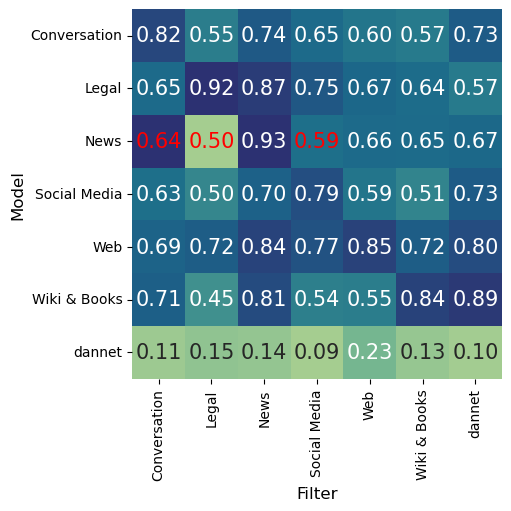

In [32]:
df = load_f1scores_from_dict(reg_f1)

mask = np.zeros_like(df)
mask[2, [0, 1, 3]] = 1  

fig, ax = plt.subplots()
sns.heatmap(df, 
            annot=True, 
            fmt='.2f',
            cmap=sns.color_palette("crest", as_cmap=True), 
            ax=ax, 
            annot_kws={"fontsize": 15}, 
            cbar=False,
            mask=mask,
            square=True)

# Define a custom annotation function to apply red color to the masked cells
def annotate_red(x):
    if x == '':
        return {'color': 'red', 'fontsize': 15}
    else:
        return {'fontsize': 15}

# Apply the custom annotation function directly to annot_kws
sns.heatmap(df, 
            annot=True, 
            fmt='.2f',
            cmap='crest', 
            ax=ax, 
            annot_kws=annotate_red(''),  # Pass the desired dictionary directly
            cbar=False,
            mask=np.logical_not(mask),  
            square=True)

ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(12)
plt.show()


In [9]:
import pickle

with open("f1_scores/f1_scores_active_learning_third_all_domains.pkl", "rb") as fp:
    ALS_f1 = pickle.load(fp)



def active_learning_comparison(f1_scores: dict,target_domains:list[str]):
    dfs = []
    for target_domain in target_domains:
        for model in f1_scores.keys():
            if target_domain in model:
                print(target_domain, model)
                dfs.append(pd.DataFrame({
                    "Source": [model],
                    "Target": [target_domain],
                    "Type": [model.split("_")[-1].capitalize() if "none" not in model else "none" +model.split("_")[-1].capitalize()],
                    "F1": [f1_scores[model][target_domain]]
                }))

    return pd.concat(dfs).pivot(index="Type", columns="Target",values="F1")


active_learning_comparison(ALS_f1, ["Legal", "Conversation", "Social Media"])




Legal model_News_Legal_margin
Legal model_News_Legal_confidence
Legal model_News_Legal_random
Conversation model_News_Conversation_margin
Conversation model_News_Conversation_confidence
Conversation model_News_Conversation_random
Social Media model_News_Social Media_margin
Social Media model_News_Social Media_confidence
Social Media model_News_Social Media_random


Target,Conversation,Legal,Social Media
Type,,,
Confidence,0.803468,0.871849,0.781818
Margin,0.789333,0.898608,0.787879
Random,0.805405,0.866880,0.722222


# F1 score vs. pct of data used

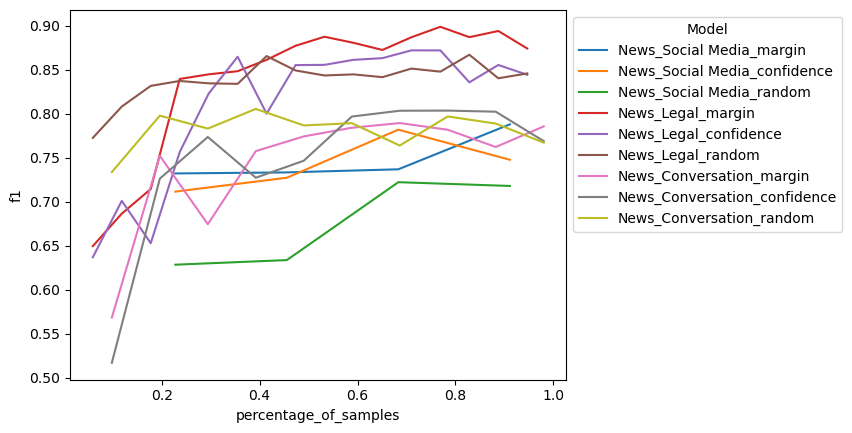

In [10]:
dfs = []

for model in ALS_f1.keys():
    if "model" in model:
        s,t,q = model.split("_")[1:]
        df = pd.read_csv(f"al_results/third/ALResult_{s}_{t}_{q}.csv")
        df["Model"] = f"{s}_{t}_{q}"
        dfs.append(df)


fig,ax=plt.subplots()

sns.lineplot(data = pd.concat(dfs), x="percentage_of_samples", y="f1", hue="Model")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))



<Axes: xlabel='Filter', ylabel='Model'>

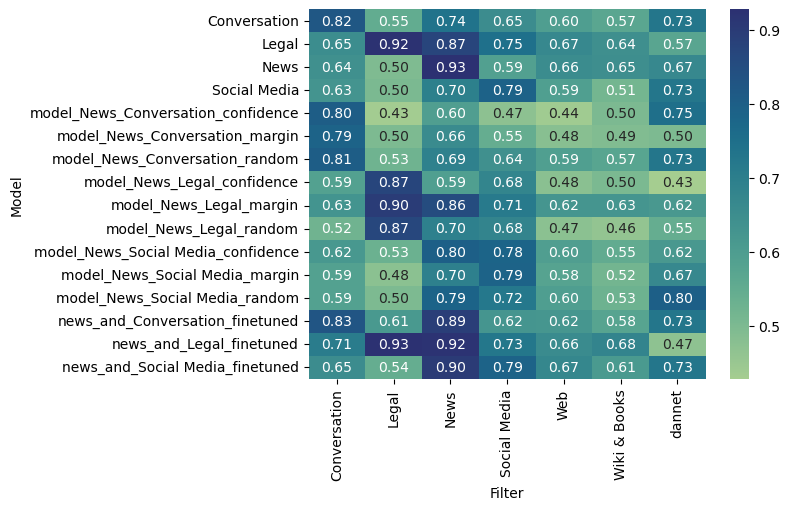

In [11]:
reg2_f1 = {key: val for key, val in reg_f1.items() if key in ["Social Media", "Conversation","Legal","News"]}


with open("f1_scores/f1_scores_news_on_filter.pkl", "rb") as fp:
    news_on_filter_f1 = dict()
    for key, val in pickle.load(fp).items():
        val.pop(None)
        news_on_filter_f1[key] = val


news_on_filter_f1.update(ALS_f1)
news_on_filter_f1.update(reg2_f1)

dfs = []


for model_type in news_on_filter_f1.keys():
    dfs.append(pd.DataFrame({'Model': [model_type]*7, 
                'Filter': news_on_filter_f1[model_type].keys(),
                'F1_scores': news_on_filter_f1[model_type].values()}))



sns.heatmap(pd.concat(dfs).pivot(index="Model", columns="Filter", values="F1_scores"), annot=True, fmt='.2f',cmap=sns.color_palette("crest", as_cmap=True))



Legal model_News_Legal_margin
Legal model_News_Legal_confidence
Legal model_News_Legal_random
Conversation model_News_Conversation_margin
Conversation model_News_Conversation_confidence
Conversation model_News_Conversation_random
Social Media model_News_Social Media_margin
Social Media model_News_Social Media_confidence
Social Media model_News_Social Media_random


<Axes: xlabel='Target', ylabel='Type'>

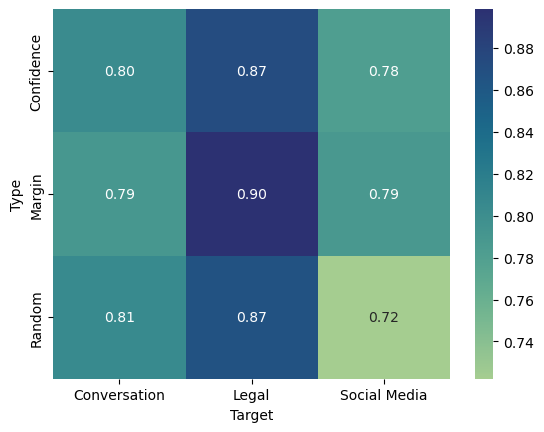

In [12]:
sns.heatmap(active_learning_comparison(ALS_f1, ["Legal", "Conversation", "Social Media"]), annot=True, fmt='.2f',cmap=sns.color_palette("crest", as_cmap=True))

